# Fashion MNIST Classification: Comparing Classical ML and Deep Learning Approaches

## Objective
In this project, I explore various machine learning and deep learning approaches to classify images from the Fashion MNIST dataset. I compare the performance of classical ML algorithms (Logistic Regression, SVM, KNN) with modern deep learning architectures (feedforward neural networks and CNNs).

## Dataset
**Fashion MNIST** is a dataset of Zalando's article images consisting of:
- 60,000 training examples
- 10,000 test examples
- 28×28 grayscale images
- 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

## Approach
I build and evaluate multiple models:
1. Classical ML: Logistic Regression, SVM, KNN
2. Baseline Neural Networks (Model 0, Model 1)
3. Convolutional Neural Networks (Model 2, Model 3)


## 1. Importing Libraries

I import all necessary libraries for:
- **PyTorch**: Deep learning framework for building neural networks
- **torchvision**: Pre-built datasets and transformations
- **scikit-learn**: Classical ML algorithms (SVM, KNN, metrics)
- **matplotlib & seaborn**: Data visualization
- **numpy**: Numerical operations
- **tqdm**: Progress bars for training loops


In [2]:
import torch 
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

import seaborn as sns

from tqdm.auto import tqdm

## 2. Loading the Fashion MNIST Dataset

The Fashion MNIST dataset is automatically downloaded from torchvision. It is split into:
- **Training set**: 60,000 images for model training
- **Test set**: 10,000 images for model evaluation

The `ToTensor()` transform converts PIL images to PyTorch tensors and normalizes pixel values to [0, 1] range.

In [5]:
# Setup the training data

train_data = datasets.FashionMNIST(
    root="data", # Where to download data to
    train=True, 
    download=True,
    transform=ToTensor(), # Convert to tensors
    target_transform=None
)

# Setup the test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

### Exploring the Dataset Structure

I examine the shape and properties of individual samples to understand the data format.


In [6]:
image, label = train_data[0]
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {label}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: 9


### Class Names and Labels

Fashion MNIST has 10 classes. Each image is labeled with an integer (0-9) corresponding to one of the fashion categories.


In [7]:
class_names = train_data.classes
class_names
print(f"Class names: {class_names}")
print(f"Class the image belongs to: {class_names[label]}")

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Class the image belongs to: Ankle boot


In [9]:
# Get a dictionary of class names and their corresponding indices

class_to_idx = train_data.class_to_idx
class_to_idx


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

### Visualising the data

Displaying the image and as expected, it is an image of an ankle boot.

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]


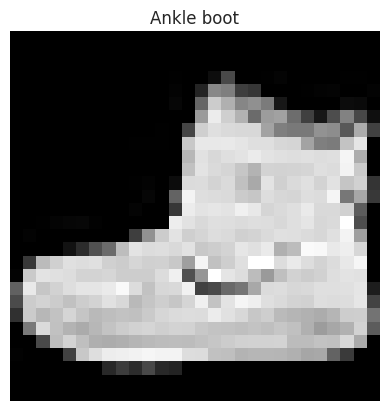

In [8]:
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

### Viewing Multiple Samples

Displaying a grid of random images from the training set to get a better sense of the variety and quality of the data.


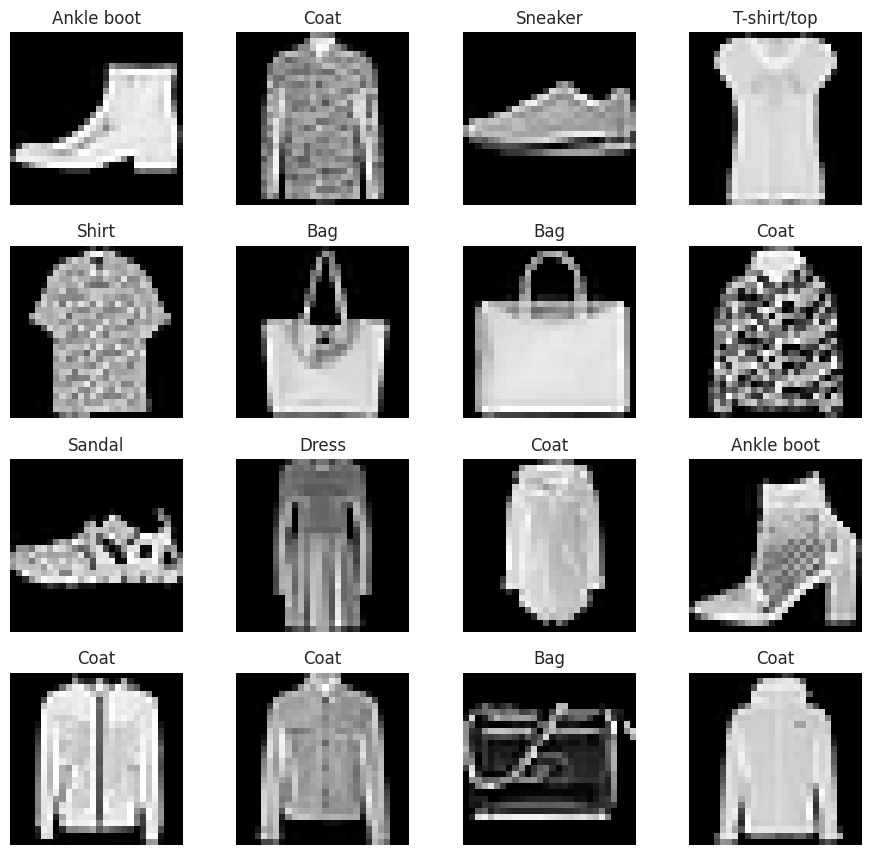

In [9]:
# Displaying more images
# torch.manual_seed(101)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    fig.tight_layout()
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
plt.show()

In [10]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### Prepare DataLoader 

Right now, the data is in the form of PyTorch datasets.

DataLoader turns the dataset into Python iterables.
More specifically, turn the data into batches (or mini batches).

- To make it more computationally efficient.
- Break it down to 32 images at a time (batch_size=32)
- Gives more chances to neural networks to update its gradients per epoch.

In [8]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True # Shuffle the data to remove any order
)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f176c5b9160>,
 <torch.utils.data.dataloader.DataLoader at 0x7f18f84fa210>)

In [12]:
# Checking out how many batches we have in the training and test dataloaders

print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fd2938bb620>, <torch.utils.data.dataloader.DataLoader object at 0x7fd2938b7c50>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [13]:
# What is inside the training dataloader?
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Label: T-shirt/top


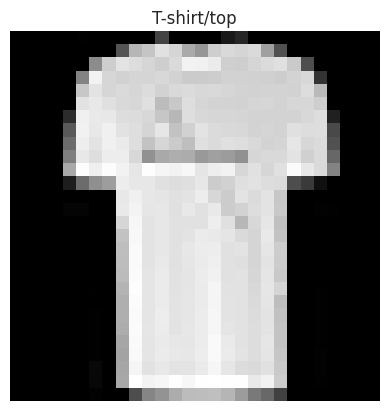

In [14]:
# Show a sample
torch.manual_seed(101)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Label: {class_names[label]}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

#### Creating device agnostic code

In [9]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda'

## 4. Setting Up Device-Agnostic Code

Device-agnostic code allows the models to run on GPU (CUDA) if available, falling back to CPU if not. This ensures maximum performance and portability across different hardware configurations.


In [16]:
# Hyperparameters
LEARNING_RATE = 0.1
NUM_EPOCHS = 15

## 5. Classical Machine Learning Approaches

Before diving into deep learning, I establish baselines using traditional machine learning algorithms. These methods help me understand:
- The difficulty of the Fashion MNIST classification task
- The performance gains I can achieve with neural networks
- Which classes are inherently difficult to distinguish

I implement three classical ML algorithms:
1. **Logistic Regression**: Linear baseline
2. **Support Vector Machine (SVM)**: Non-linear kernel methods  
3. **K-Nearest Neighbors (KNN)**: Instance-based learning


In [17]:
import torch.nn.functional as F

class OVRLogisticRegression(nn.Module):
    def __init__(self, input_dim: int, n_classes: int):
        super().__init__()
        self.classifier = nn.Linear(input_dim, n_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input
        return self.classifier(x)

model_lr = OVRLogisticRegression(input_dim=28*28, n_classes=len(class_names)).to(device)
model_lr

OVRLogisticRegression(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_lr.parameters(), lr=LEARNING_RATE)

In [19]:
# Training loop
train_losses, test_losses = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    model_lr.train()

    train_loss = 0
    train_correct = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        y_one_hot = F.one_hot(y, num_classes=len(class_names)).float().to(device)
        logits = model_lr(X)

        loss = criterion(logits, y_one_hot)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (logits.argmax(dim=1) == y).sum().item()

    train_loss /= len(train_dataloader)
    train_acc = train_correct / len(train_dataloader.dataset)

    model_lr.eval()
    test_loss = 0
    test_correct = 0

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_one_hot = F.one_hot(y_test, num_classes=len(class_names)).float().to(device)
            test_logits = model_lr(X_test)

            test_loss += criterion(test_logits, y_one_hot).item()
            test_correct += (test_logits.argmax(dim=1) == y_test).sum().item()

    test_loss /= len(test_dataloader)
    test_acc = test_correct / len(test_dataloader.dataset)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(
        f"Epoch: {epoch}/{NUM_EPOCHS} | "
        f"Train loss: {train_loss:.4f} | "
        f"Train acc: {train_acc:.4f} | "
        f"Test loss: {test_loss:.4f} | "
        f"Test acc: {test_acc:.4f}"
    )

print(f"Training Complete | Final Training Loss: {train_losses[-1]:.4f} | Final Test Loss: {test_losses[-1]:.4f}")

Epoch: 1/15 | Train loss: 0.1627 | Train acc: 0.7258 | Test loss: 0.1325 | Test acc: 0.7619
Epoch: 2/15 | Train loss: 0.1209 | Train acc: 0.7937 | Test loss: 0.1178 | Test acc: 0.7898
Epoch: 3/15 | Train loss: 0.1109 | Train acc: 0.8092 | Test loss: 0.1114 | Test acc: 0.8034
Epoch: 4/15 | Train loss: 0.1055 | Train acc: 0.8178 | Test loss: 0.1071 | Test acc: 0.8114
Epoch: 5/15 | Train loss: 0.1020 | Train acc: 0.8235 | Test loss: 0.1044 | Test acc: 0.8151
Epoch: 6/15 | Train loss: 0.0994 | Train acc: 0.8270 | Test loss: 0.1023 | Test acc: 0.8171
Epoch: 7/15 | Train loss: 0.0973 | Train acc: 0.8312 | Test loss: 0.1008 | Test acc: 0.8198
Epoch: 8/15 | Train loss: 0.0957 | Train acc: 0.8321 | Test loss: 0.0993 | Test acc: 0.8237
Epoch: 9/15 | Train loss: 0.0944 | Train acc: 0.8359 | Test loss: 0.0982 | Test acc: 0.8261
Epoch: 10/15 | Train loss: 0.0932 | Train acc: 0.8367 | Test loss: 0.0971 | Test acc: 0.8272
Epoch: 11/15 | Train loss: 0.0923 | Train acc: 0.8383 | Test loss: 0.0961 | Tes

True Label: Shirt | Pred Label: Shirt | Pred Prob: 0.4578


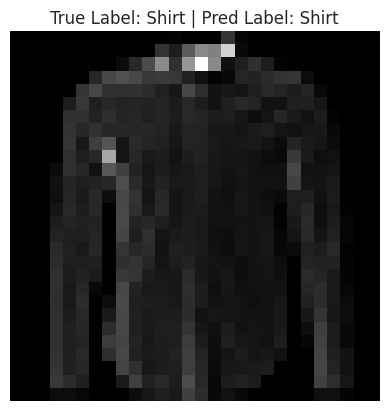

In [20]:
model_lr.eval()
sample_idx = torch.randint(0, len(test_dataloader), size=[1]).item()
sample_image, sample_label = test_data[sample_idx]

with torch.inference_mode():
    logits = model_lr(sample_image.unsqueeze(0).to(device))
    pred_prob = torch.sigmoid(logits).squeeze().cpu()

pred_label = int(torch.argmax(pred_prob).item())

print(f"True Label: {class_names[sample_label]} | Pred Label: {class_names[pred_label]} | Pred Prob: {pred_prob[pred_label]:.4f}")
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.title(f"True Label: {class_names[sample_label]} | Pred Label: {class_names[pred_label]}")
plt.axis(False)
plt.show()

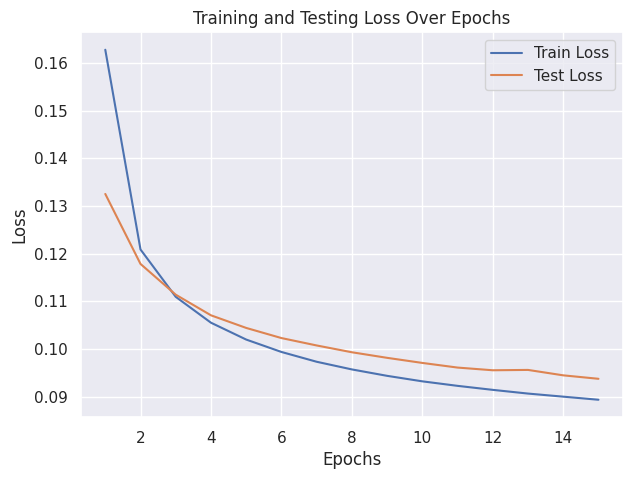

In [22]:
import seaborn as sns

sns.set_style(style="darkgrid")
plt.figure(figsize=(7, 5))
sns.lineplot(x=range(1, NUM_EPOCHS + 1), y=train_losses, label="Train Loss")
sns.lineplot(x=range(1, NUM_EPOCHS + 1), y=test_losses, label="Test Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

As I have established that the data is not linearly separable and I am only getting around 82% test accuracy using One-vs-Rest logistic regression, I decided to use Support Vector Machines with Kernels.

### Support Vector Machine with RBF Kernel

Using SVM with RBF (Radial Basis Function) kernel for non-linear classification.
Will use GridSearchCV to find optimal hyperparameters (C and gamma).


In [23]:
# Import necessary libraries for SVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from timeit import default_timer as timer
import pandas as pd

In [24]:
# Prepare data for sklearn SVM
# Convert PyTorch datasets to numpy arrays and flatten images

# Extract training data
X_train = train_data.data.numpy()
y_train = train_data.targets.numpy()

# Extract test data
X_test = test_data.data.numpy()
y_test = test_data.targets.numpy()

# Flatten the images from 28x28 to 784
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Training data shape: {X_train_flat.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test_flat.shape}")
print(f"Test labels shape: {y_test.shape}")


Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)


In [25]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print("Data normalized successfully")
print(f"Training data mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")


Data normalized successfully
Training data mean: -0.0000, std: 1.0000


In [26]:
# Use a subset for GridSearch (SVM is computationally expensive on large datasets)
# Using 10,000 samples for faster hyperparameter tuning
subset_size = 10000
np.random.seed(101)
subset_indices = np.random.choice(len(X_train_scaled), subset_size, replace=False)

X_train_subset = X_train_scaled[subset_indices]
y_train_subset = y_train[subset_indices]

print(f"Subset size for GridSearch: {X_train_subset.shape}")


Subset size for GridSearch: (10000, 784)


In [27]:
# Define the parameter grid for GridSearch
# C: Regularization parameter
# gamma: Kernel coefficient for 'rbf'
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

print("Parameter grid for GridSearch:")
print(param_grid)


Parameter grid for GridSearch:
{'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}


In [28]:
# Perform GridSearchCV
print("Starting GridSearchCV...")
print("="*60)

start_time = timer()

# Create SVM classifier with RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=101)

# Create GridSearchCV object
# cv=3 for 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=svm_rbf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train_subset, y_train_subset)

end_time = timer()
print("="*60)
print(f"GridSearch completed in {end_time - start_time:.2f} seconds")


Starting GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END .................................C=0.1, gamma=0.001; total time= 1.5min
[CV] END .................................C=0.1, gamma=scale; total time= 1.5min
[CV] END ..................................C=0.1, gamma=auto; total time= 1.5min
[CV] END ..................................C=0.1, gamma=auto; total time= 1.5min
[CV] END .................................C=0.1, gamma=0.001; total time= 1.5min
[CV] END ..................................C=0.1, gamma=auto; total time= 1.5min
[CV] END .................................C=0.1, gamma=0.001; total time= 1.5min
[CV] END .................................C=0.1, gamma=scale; total time= 1.6min
[CV] END .................................C=0.1, gamma=scale; total time= 1.6min
[CV] END ...................................C=1, gamma=scale; total time= 1.0min
[CV] END ...................................C=1, gamma=scale; total time= 1.1min
[CV] END ..............

In [29]:
# Display best parameters and score
print("Best parameters found by GridSearch:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Get detailed results
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.sort_values('rank_test_score')
print("\nTop 5 parameter combinations:")
print(results_df.head())


Best parameters found by GridSearch:
{'C': 10, 'gamma': 0.001}

Best cross-validation score: 0.8650

Top 5 parameter combinations:
                          params  mean_test_score  std_test_score  \
14     {'C': 10, 'gamma': 0.001}           0.8650        0.004106   
13    {'C': 10, 'gamma': 'auto'}           0.8641        0.004467   
12   {'C': 10, 'gamma': 'scale'}           0.8637        0.004825   
19   {'C': 100, 'gamma': 'auto'}           0.8598        0.004645   
18  {'C': 100, 'gamma': 'scale'}           0.8595        0.004842   

    rank_test_score  
14                1  
13                2  
12                3  
19                4  
18                5  


In [30]:
# Train final model on full training data with best parameters
print("Training final SVM model on full training data with best parameters...")
print("="*60)

start_time = timer()

# Create SVM with best parameters
best_svm = SVC(
    kernel='rbf',
    C=grid_search.best_params_['C'],
    gamma=grid_search.best_params_['gamma'],
    random_state=101
)

# Train on full training data
best_svm.fit(X_train_scaled, y_train)

end_time = timer()
print(f"Training completed in {end_time - start_time:.2f} seconds")
print("="*60)


Training final SVM model on full training data with best parameters...
Training completed in 169.36 seconds


In [31]:
# Evaluate on training and test data
train_predictions = best_svm.predict(X_train_scaled)
test_predictions = best_svm.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9736
Test Accuracy: 0.8970


In [32]:
# Detailed classification report
print("Classification Report:")
print("="*60)
print(classification_report(y_test, test_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.85      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.81      0.82      0.82      1000
       Dress       0.90      0.91      0.90      1000
        Coat       0.83      0.83      0.83      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.75      0.71      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



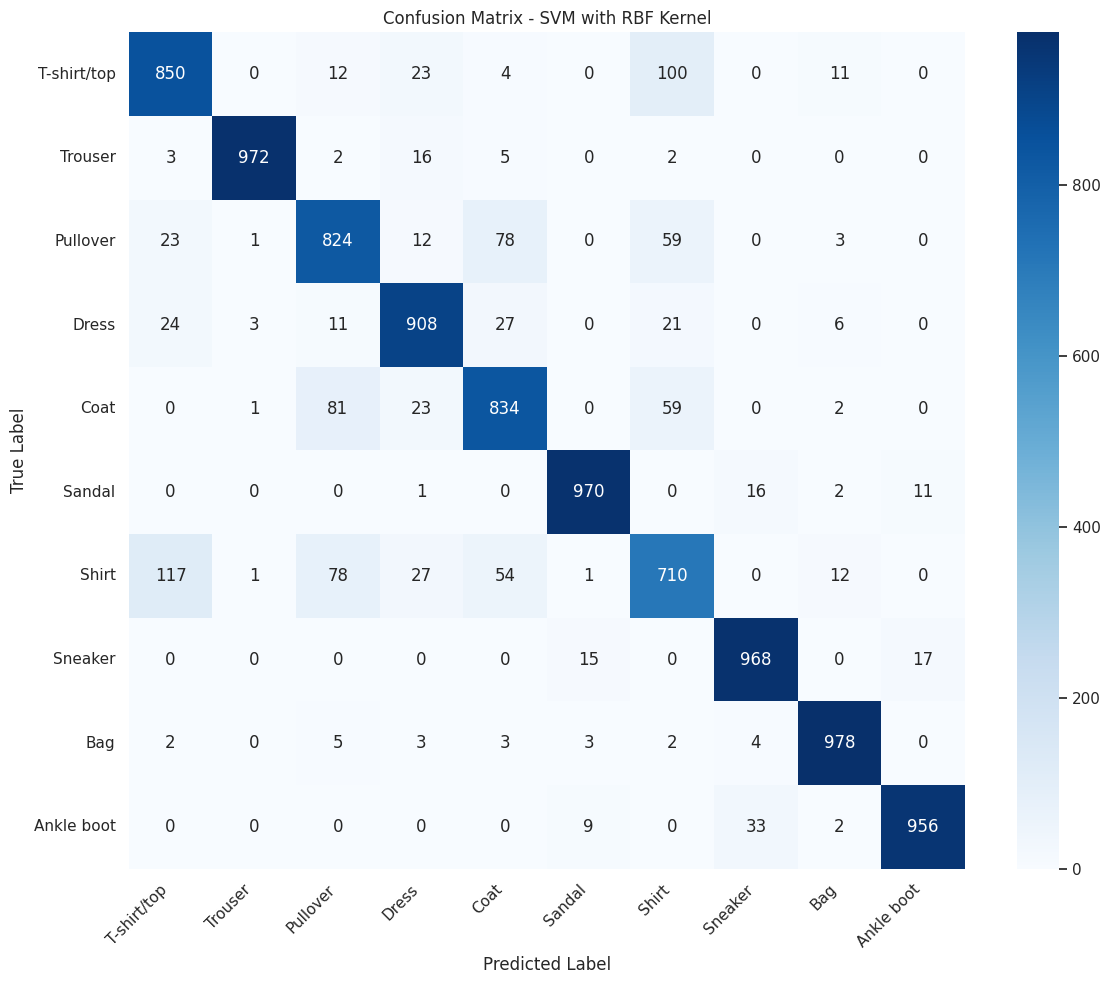

In [33]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SVM with RBF Kernel')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


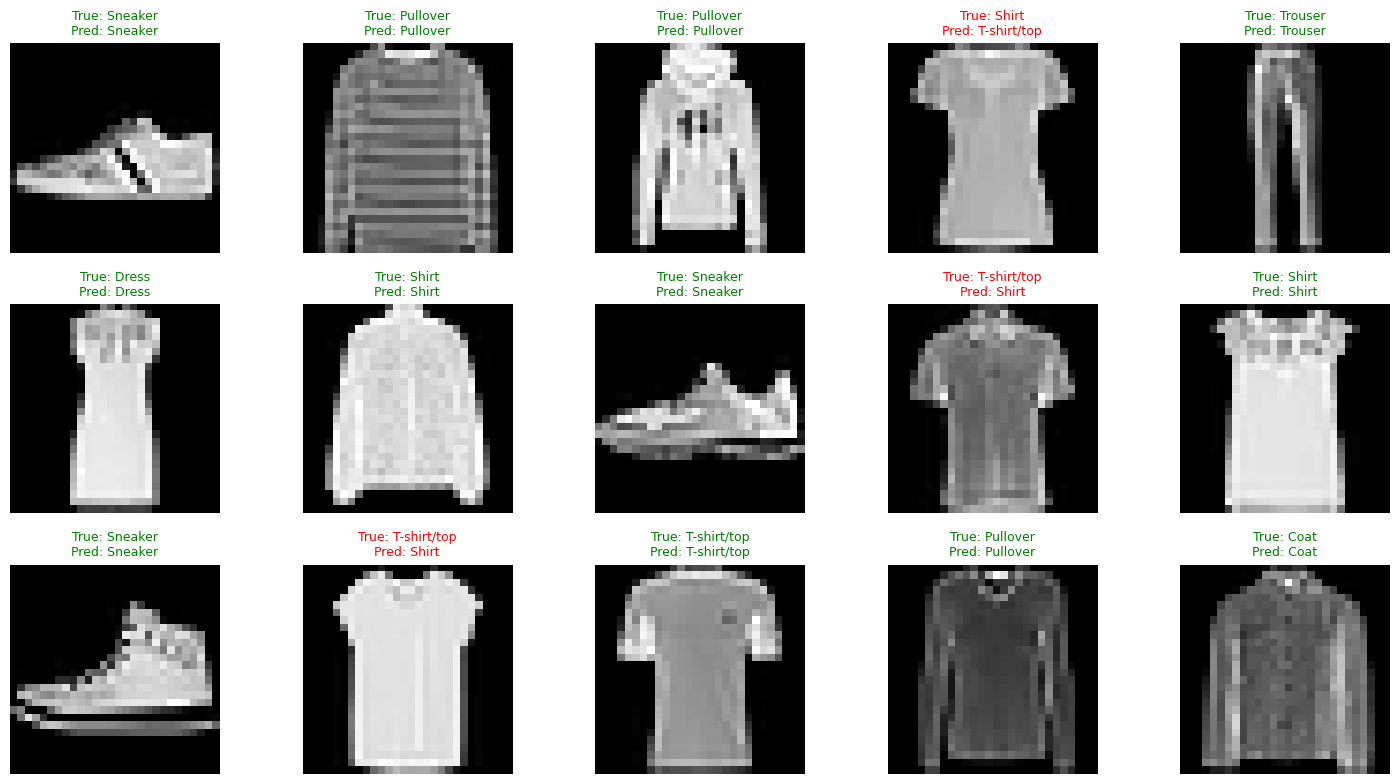

In [34]:
# Visualize some predictions
np.random.seed(101)
fig = plt.figure(figsize=(15, 8))
rows, cols = 3, 5

for i in range(1, rows * cols + 1):
    random_idx = np.random.randint(0, len(X_test))
    
    # Get image and prediction
    img = X_test[random_idx]
    true_label = y_test[random_idx]
    pred_label = test_predictions[random_idx]
    
    # Create subplot
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
    
    # Color title based on correct/incorrect prediction
    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
              color=title_color, fontsize=9)
    plt.axis(False)

plt.tight_layout()
plt.show()


In [35]:
# Model Summary
print("="*60)
print("SVM RBF Kernel Model Summary")
print("="*60)
print(f"Best Hyperparameters: C={grid_search.best_params_['C']}, gamma={grid_search.best_params_['gamma']}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("="*60)
print("\nComparison with Logistic Regression:")
print(f"Logistic Regression Test Accuracy: 0.8309")
print(f"SVM RBF Test Accuracy: {test_accuracy:.4f}")
print(f"Improvement: {test_accuracy - 0.8309:.4f}")
print("="*60)

SVM RBF Kernel Model Summary
Best Hyperparameters: C=10, gamma=0.001
Training Accuracy: 0.9736
Test Accuracy: 0.8970

Comparison with Logistic Regression:
Logistic Regression Test Accuracy: 0.8309
SVM RBF Test Accuracy: 0.8970
Improvement: 0.0661


### K-Nearest Neighbors (KNN)

Using KNN classifier for Fashion MNIST.
Will test different k values and use cross-validation to find the optimal k.


In [37]:
# Import KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [38]:
# Test different k values to find optimal k
# Using a smaller subset for faster computation
subset_size_knn = 5000
np.random.seed(101)
knn_subset_indices = np.random.choice(len(X_train_scaled), subset_size_knn, replace=False)

X_train_knn_subset = X_train_scaled[knn_subset_indices]
y_train_knn_subset = y_train[knn_subset_indices]

print(f"Using subset of {subset_size_knn} samples for k optimization")

# Test k values from 1 to 15
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
k_scores = []

print("\nTesting different k values...")
print("="*60)

for k in k_values:
    start_time = timer()
    
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    
    # Perform 3-fold cross-validation
    scores = cross_val_score(knn, X_train_knn_subset, y_train_knn_subset, cv=3, scoring='accuracy')
    mean_score = scores.mean()
    k_scores.append(mean_score)
    
    end_time = timer()
    
    print(f"k={k:2d} | Mean CV Accuracy: {mean_score:.4f} | Time: {end_time - start_time:.2f}s")

print("="*60)


Using subset of 5000 samples for k optimization

Testing different k values...
k= 1 | Mean CV Accuracy: 0.7870 | Time: 0.19s
k= 3 | Mean CV Accuracy: 0.7992 | Time: 0.16s
k= 5 | Mean CV Accuracy: 0.8024 | Time: 0.15s
k= 7 | Mean CV Accuracy: 0.7976 | Time: 0.15s
k= 9 | Mean CV Accuracy: 0.7902 | Time: 0.15s
k=11 | Mean CV Accuracy: 0.7878 | Time: 0.15s
k=13 | Mean CV Accuracy: 0.7872 | Time: 0.15s
k=15 | Mean CV Accuracy: 0.7860 | Time: 0.15s


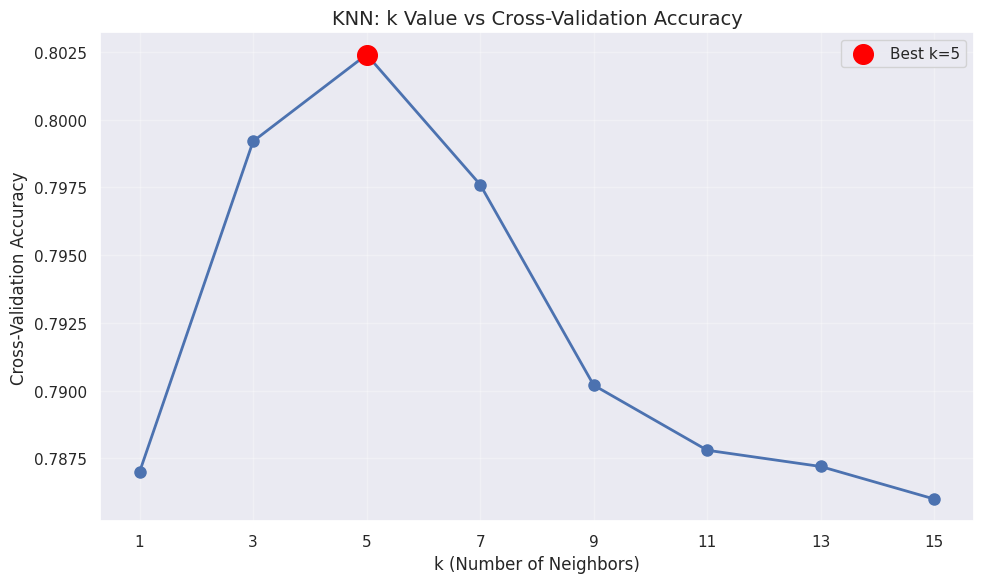

Best k value: 5
Best cross-validation accuracy: 0.8024


In [39]:
# Visualize k values vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('KNN: k Value vs Cross-Validation Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Mark the best k
best_k_idx = np.argmax(k_scores)
best_k = k_values[best_k_idx]
best_score = k_scores[best_k_idx]
plt.scatter(best_k, best_score, color='red', s=200, zorder=5, label=f'Best k={best_k}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best k value: {best_k}")
print(f"Best cross-validation accuracy: {best_score:.4f}")


In [40]:
# Train KNN on full training data with best k
print(f"Training KNN with k={best_k} on full training data...")
print("="*60)

start_time = timer()

# Create KNN classifier with best k
knn_final = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)

# Train on full training data
knn_final.fit(X_train_scaled, y_train)

end_time = timer()
print(f"Training completed in {end_time - start_time:.2f} seconds")
print("="*60)


Training KNN with k=5 on full training data...
Training completed in 0.02 seconds


In [41]:
# Make predictions
print("Making predictions on test data...")
start_time = timer()

knn_test_predictions = knn_final.predict(X_test_scaled)

end_time = timer()
print(f"Prediction completed in {end_time - start_time:.2f} seconds")

# Calculate accuracy
knn_train_predictions = knn_final.predict(X_train_scaled)
knn_train_accuracy = accuracy_score(y_train, knn_train_predictions)
knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)

print(f"\nTraining Accuracy: {knn_train_accuracy:.4f}")
print(f"Test Accuracy: {knn_test_accuracy:.4f}")


Making predictions on test data...
Prediction completed in 3.22 seconds

Training Accuracy: 0.9011
Test Accuracy: 0.8533


In [42]:
# Detailed classification report for KNN
print("Classification Report (KNN):")
print("="*60)
print(classification_report(y_test, knn_test_predictions, target_names=class_names))


Classification Report (KNN):
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.86      0.81      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.74      0.80      0.77      1000
       Dress       0.90      0.86      0.88      1000
        Coat       0.77      0.77      0.77      1000
      Sandal       0.99      0.84      0.91      1000
       Shirt       0.64      0.59      0.61      1000
     Sneaker       0.88      0.96      0.92      1000
         Bag       0.98      0.93      0.95      1000
  Ankle boot       0.90      0.96      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



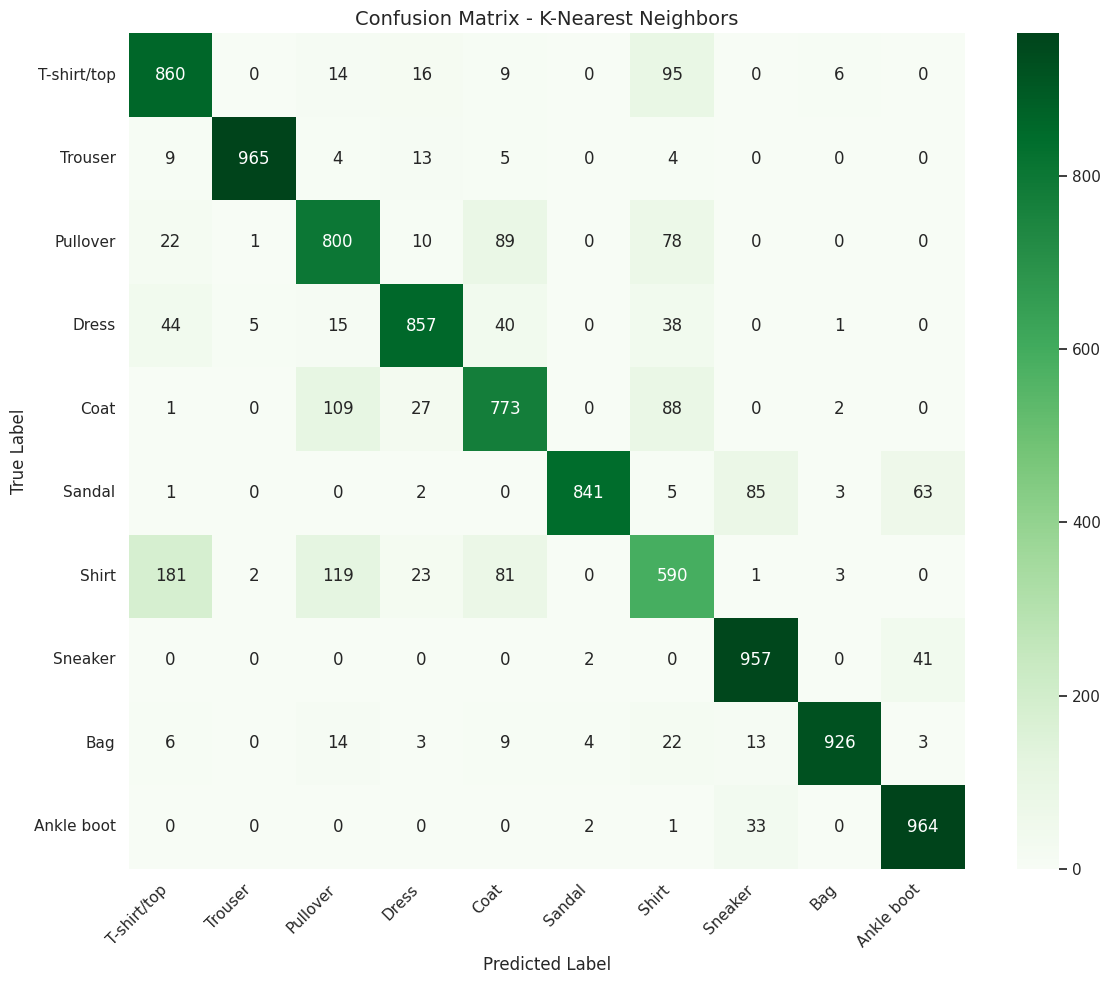

In [43]:
# Visualize confusion matrix for KNN
knn_cm = confusion_matrix(y_test, knn_test_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - K-Nearest Neighbors', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


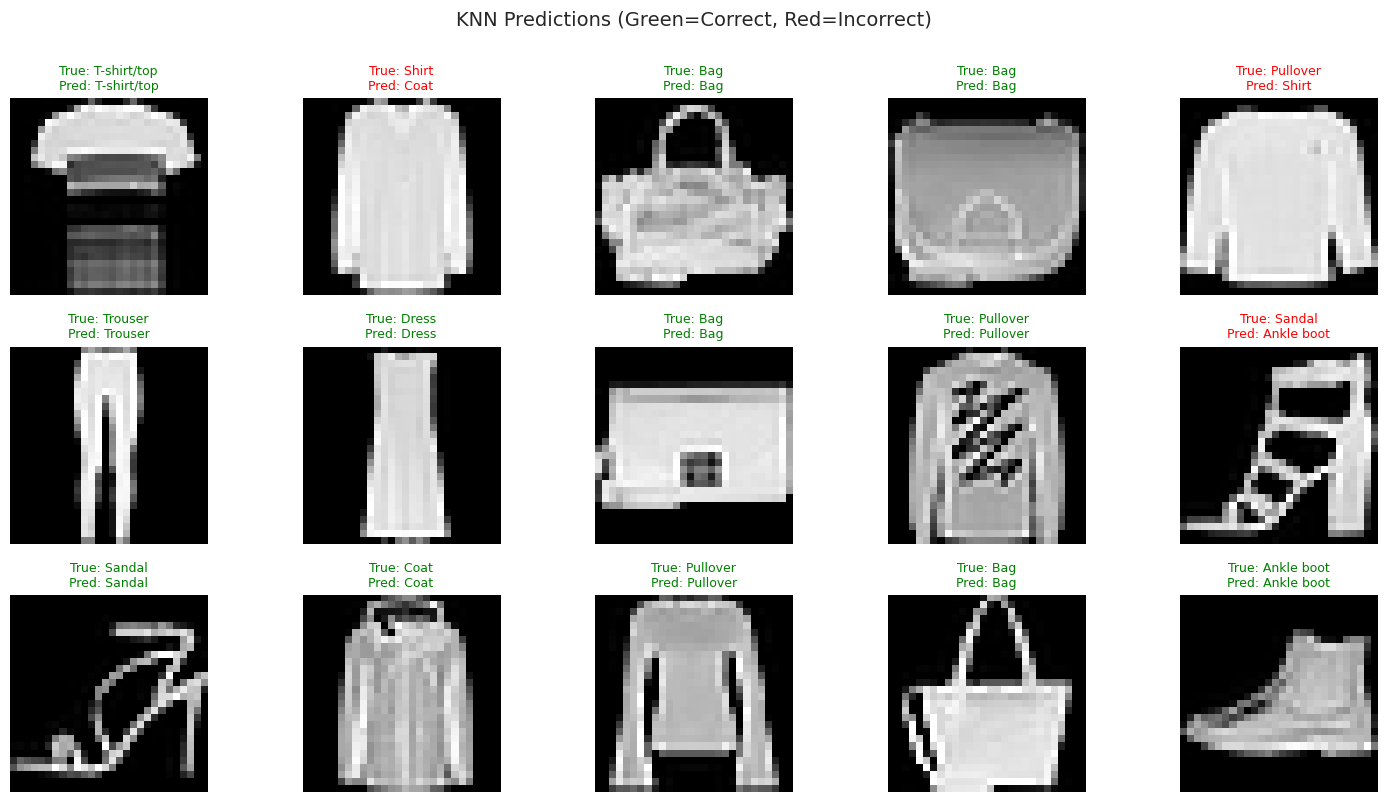

In [44]:
# Visualize some predictions from KNN
np.random.seed(42)
fig = plt.figure(figsize=(15, 8))
rows, cols = 3, 5

for i in range(1, rows * cols + 1):
    random_idx = np.random.randint(0, len(X_test))
    
    # Get image and prediction
    img = X_test[random_idx]
    true_label = y_test[random_idx]
    pred_label = knn_test_predictions[random_idx]
    
    # Create subplot
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
    
    # Color title based on correct/incorrect prediction
    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
              color=title_color, fontsize=9)
    plt.axis(False)

plt.suptitle('KNN Predictions (Green=Correct, Red=Incorrect)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


In [45]:
# KNN Model Summary and Comparison
print("="*60)
print("K-Nearest Neighbors Model Summary")
print("="*60)
print(f"Best k value: {best_k}")
print(f"Training Accuracy: {knn_train_accuracy:.4f}")
print(f"Test Accuracy: {knn_test_accuracy:.4f}")
print("="*60)

# Comparison with other models
print("\n" + "="*60)
print("Model Comparison Summary")
print("="*60)
models_comparison = {
    'Logistic Regression': 0.8309,
    'SVM RBF Kernel': 0.8970,
    'K-Nearest Neighbors': knn_test_accuracy
}

for model_name, accuracy in models_comparison.items():
    print(f"{model_name:25s}: {accuracy:.4f}")

print("="*60)
best_model = max(models_comparison, key=models_comparison.get)
print(f"Best Model: {best_model} with {models_comparison[best_model]:.4f} accuracy")
print("="*60)


K-Nearest Neighbors Model Summary
Best k value: 5
Training Accuracy: 0.9011
Test Accuracy: 0.8533

Model Comparison Summary
Logistic Regression      : 0.8309
SVM RBF Kernel           : 0.8970
K-Nearest Neighbors      : 0.8533
Best Model: SVM RBF Kernel with 0.8970 accuracy


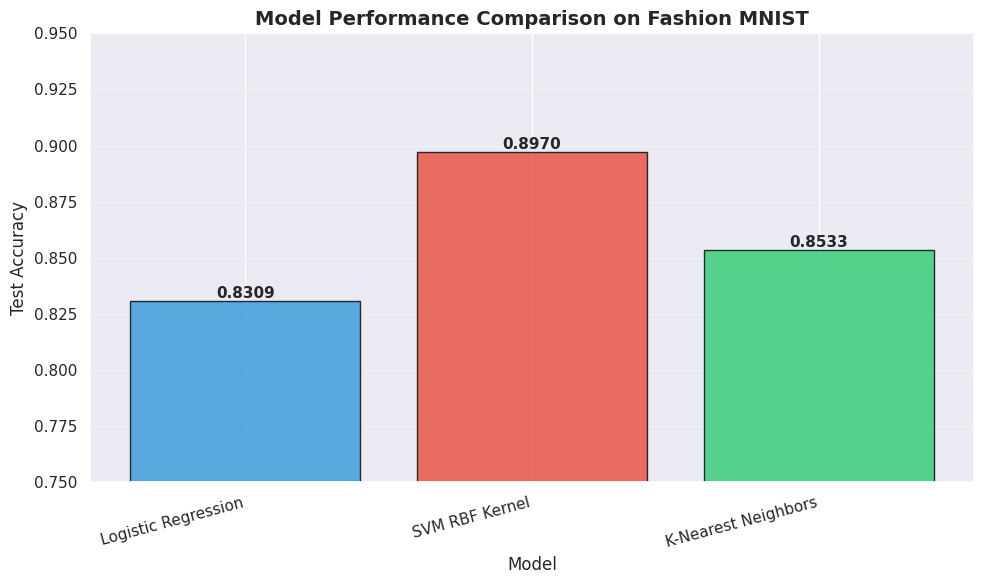

In [46]:
# Visualize model comparison
plt.figure(figsize=(10, 6))
models = list(models_comparison.keys())
accuracies = list(models_comparison.values())

bars = plt.bar(models, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Model Performance Comparison on Fashion MNIST', fontsize=14, fontweight='bold')
plt.ylim([0.75, 0.95])
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Model 0: Baseline Model

Simple model -> Will try and improve upon with subsequent models/experiments.

In other words, start simply and add complexity if necessary

In [30]:
from torch import nn

# Model Architecture
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [31]:
torch.manual_seed(42)

# Create an instance of the model
model_0 = FashionMNISTModelV0(
    input_shape=28 * 28, # 28*28 = 784
    hidden_units=10, 
    output_shape=len(class_names)
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [32]:
dummy_x = torch.rand([1, 1, 28, 28]).to(device)
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Setup loss, optimizer and evaluation metrics

* Loss function - since I am working with multi-class data, the loss function should be `nn.CrossEntropyLoss()`

* Optimizer - I use `torch.optim.SGD()` Stochastic Gradient Descent.

* Evaluation Metric - Since I am working on a classification problem, I use accuracy as the evaluation metric. 
 

In [33]:
LEARNING_RATE = 0.1 # Tweaked each epoch

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)

## 6. Deep Learning Approaches

Now transitioning to neural networks. Unlike classical ML, deep learning models can automatically learn hierarchical feature representations from raw pixel data.

**Progression of Models**:
- **Model 0**: Baseline feedforward network
- **Model 1**: Adding non-linearity with ReLU
- **Model 2**: Convolutional Neural Network (CNN)
- **Model 3**: Advanced CNN with regularization

Each model builds upon insights gained from the previous one.


### Time the experiements

In [10]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")
    return total_time

Common Accuracy Function

In [13]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Creating a training loop and training the model on batches of data

- Loop through epochs.
- Loop through training batches, perform training steps, calculating the train loss *per batch*
- Loop through testing batches, perform testing steps, calculate the test loss *per batch*
- Print out what is happening.
- Time it all 

In [34]:
from tqdm.auto import tqdm

# Set seed and start timer
torch.manual_seed(42)
train_time = timer()

# Set the number of epochs
NUM_EPOCHS = 15  # Start with 3 for testing, increase to 10-15 later

# Creating a training loop and training the model on batches of data
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}\n---------")
    
    ### Training
    train_loss = 0
    train_correct = 0  # Track correct predictions across ALL batches
    
    model_0.train()  # Set to training mode ONCE before loop
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        # Move data to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model_0(X)

        # Calculate loss per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Calculate correct predictions for this batch
        train_correct += (y_pred.argmax(dim=1) == y).sum().item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimiser step
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Calculate average train loss and accuracy across ALL batches
    train_loss /= len(train_dataloader)
    train_acc = train_correct / len(train_dataloader.dataset)

    ### Testing
    test_loss = 0
    test_correct = 0  # Track correct predictions across ALL batches
    
    model_0.eval()

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # Move data to device
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            # Make predictions
            test_pred = model_0(X_test)

            # Calculate loss per batch
            test_loss += loss_fn(test_pred, y_test).item()
            
            # Calculate correct predictions for this batch
            test_correct += (test_pred.argmax(dim=1) == y_test).sum().item()
            
    # Calculate average test loss and accuracy across ALL batches
    test_loss /= len(test_dataloader)
    test_acc = test_correct / len(test_dataloader.dataset)

    # Print out what's happening with proper formatting
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}\n")

# Calculate the training time
train_time_end = timer()
print_train_time(start=train_time, end=train_time_end)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


  7%|▋         | 1/15 [00:02<00:33,  2.36s/it]

Train loss: 0.5904 | Train acc: 0.7917 | Test loss: 0.5095 | Test acc: 0.8203

Epoch: 2/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 13%|█▎        | 2/15 [00:04<00:30,  2.35s/it]

Train loss: 0.4763 | Train acc: 0.8332 | Test loss: 0.4799 | Test acc: 0.8318

Epoch: 3/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 20%|██        | 3/15 [00:07<00:28,  2.35s/it]

Train loss: 0.4550 | Train acc: 0.8405 | Test loss: 0.4766 | Test acc: 0.8341

Epoch: 4/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 27%|██▋       | 4/15 [00:09<00:25,  2.35s/it]

Train loss: 0.4425 | Train acc: 0.8447 | Test loss: 0.4631 | Test acc: 0.8374

Epoch: 5/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|███▎      | 5/15 [00:11<00:24,  2.42s/it]

Train loss: 0.4358 | Train acc: 0.8470 | Test loss: 0.4687 | Test acc: 0.8327

Epoch: 6/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 40%|████      | 6/15 [00:14<00:21,  2.44s/it]

Train loss: 0.4291 | Train acc: 0.8497 | Test loss: 0.4589 | Test acc: 0.8363

Epoch: 7/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 47%|████▋     | 7/15 [00:16<00:19,  2.45s/it]

Train loss: 0.4248 | Train acc: 0.8522 | Test loss: 0.4877 | Test acc: 0.8332

Epoch: 8/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 53%|█████▎    | 8/15 [00:19<00:17,  2.46s/it]

Train loss: 0.4227 | Train acc: 0.8506 | Test loss: 0.4722 | Test acc: 0.8338

Epoch: 9/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 60%|██████    | 9/15 [00:21<00:14,  2.43s/it]

Train loss: 0.4203 | Train acc: 0.8526 | Test loss: 0.4713 | Test acc: 0.8347

Epoch: 10/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|██████▋   | 10/15 [00:24<00:12,  2.44s/it]

Train loss: 0.4175 | Train acc: 0.8529 | Test loss: 0.4628 | Test acc: 0.8363

Epoch: 11/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 73%|███████▎  | 11/15 [00:26<00:09,  2.45s/it]

Train loss: 0.4160 | Train acc: 0.8524 | Test loss: 0.4622 | Test acc: 0.8365

Epoch: 12/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 80%|████████  | 12/15 [00:29<00:07,  2.46s/it]

Train loss: 0.4125 | Train acc: 0.8554 | Test loss: 0.4633 | Test acc: 0.8368

Epoch: 13/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 87%|████████▋ | 13/15 [00:31<00:04,  2.46s/it]

Train loss: 0.4106 | Train acc: 0.8554 | Test loss: 0.4629 | Test acc: 0.8398

Epoch: 14/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 93%|█████████▎| 14/15 [00:34<00:02,  2.45s/it]

Train loss: 0.4098 | Train acc: 0.8550 | Test loss: 0.4628 | Test acc: 0.8413

Epoch: 15/15
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]

Train loss: 0.4078 | Train acc: 0.8562 | Test loss: 0.4762 | Test acc: 0.8294

Train time on device cuda: 36.376 seconds


36.37615521415137

### Make predictions and get Model 0 inference

In [35]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
    """
    Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): The model to evaluate.
        data_loader (torch.utils.data.DataLoader): The data loader to evaluate the model on.
        loss_fn (torch.nn.Module): The loss function to evaluate the model on.
        accuracy_fn (function): The accuracy function to evaluate the model on.
        device (torch.device): The device to evaluate the model on.

    Returns:
        (dict): A dictionary containing the results of the model predicting on the data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

### Setting Up Loss Function and Optimizer

**Loss Function**: `CrossEntropyLoss()`
- Appropriate for multi-class classification
- Combines LogSoftmax and NLLLoss
- Penalizes confident incorrect predictions more heavily

**Optimizer**: Stochastic Gradient Descent (SGD)
- Learning rate: 0.1 (relatively high for faster initial learning)
- Updates weights based on gradients from backpropagation


In [36]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_0_results

100%|██████████| 313/313 [00:00<00:00, 1164.99it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4761614203453064,
 'model_acc': 82.93730031948881}

### Creating Utility Functions

I create helper functions for tracking performance:
- **`print_train_time()`**: Measures and displays training duration
- **`accuracy_fn()`**: Calculates classification accuracy

These utilities are reused across all models for consistent evaluation.


### Model 1: Building a better model with non-linearity

In [37]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # 28 *28 -> 784
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), # Add a non-linear activation function
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() # Add a non-linear activation function
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [43]:
LEARNING_RATE = 0.1
NUM_EPOCHS = 15

In [39]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=28*28, hidden_units=10, output_shape=len(class_names)).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

### Training Model 0

The training loop follows the standard PyTorch workflow:

**Training Phase** (per epoch):
1. Set model to training mode
2. Iterate through batches
3. Forward pass: compute predictions
4. Calculate loss
5. Backward pass: compute gradients
6. Update weights with optimizer

**Testing Phase** (per epoch):
1. Set model to evaluation mode
2. Disable gradient computation (faster, less memory)
3. Compute test loss and accuracy

I train for 15 epochs, monitoring both training and test metrics to detect overfitting.


In [40]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [41]:
# Setup loss, optimizer and evaluation metrics
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=LEARNING_RATE)

Making a generic training/testing/evaluation function

function for :
- training loop - `train_step()`
- testing loop - `test_step()`

In [18]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               accuracy_fn, 
               device: torch.device = device):
    """Performs a training step on a model.

    Args:
        model (torch.nn.Module): The model to train.
        data_loader (torch.utils.data.DataLoader): The data loader to train the model on.
        loss_fn (torch.nn.Module): The loss function to train the model on.
        optimizer (torch.optim.Optimizer): The optimizer to train the model on.
        accuracy_fn (function): The accuracy function to train the model on.
        device (torch.device): The device to train the model on.

    Returns:
        (dict): A dictionary containing the results of the training step.
    """
    train_loss, train_acc = 0, 0
    # Put model in training mode
    model.train()
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Calculate the accuracy (Accumulate)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.2f} | Train acc: {train_acc:.2f}%")

    return {"model_name": model.__class__.__name__,
            "model_loss": train_loss,
            "model_acc": train_acc}

### Evaluating Model 0

Using the `eval_model()` function to get final test performance. This provides a clean summary of the model's generalization capability.


In [19]:
def test_step(model: torch.nn.Module, 
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              accuracy_fn, 
              device: torch.device = device):
    """Performs a testing step on a model.
    
    Args:
        model (torch.nn.Module): The model to test.
        data_loader (torch.utils.data.DataLoader): The data loader to test the model on.
        loss_fn (torch.nn.Module): The loss function to test the model on.
        accuracy_fn (function): The accuracy function to test the model on.
        device (torch.device): The device to test the model on.

    Returns:
        (dict): A dictionary containing the results of the testing step.
    """
    test_loss, test_acc = 0, 0
    # Put model in evaluation mode
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}%")
    
    return {"model_name": model.__class__.__name__,
            "model_loss": test_loss,
            "model_acc": test_acc}

### 6.2 Model 1: Adding Non-Linearity with ReLU

Model 0's linear architecture limits its expressiveness. Model 1 introduces **ReLU (Rectified Linear Unit)** activation functions.

**Key Improvement**: Non-linear activations
- ReLU: f(x) = max(0, x)
- Introduces non-linearity, allowing the network to learn complex patterns
- Enables the network to create non-linear decision boundaries
- Addresses the "vanishing gradient" problem better than sigmoid/tanh

**Architecture Changes**:
- Same structure as Model 0 (784 → 10 → 10)
- Added ReLU activations after linear layers
- Can now learn more complex feature representations


In [44]:
train_time_start = timer()

for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}\n---------")
    train_step(model=model_1, 
               data_loader=train_dataloader, 
               loss_fn=loss_fn, 
               optimizer=optimizer, 
               accuracy_fn=accuracy_fn, 
               device=device)
    test_step(model=model_1, 
              data_loader=test_dataloader, 
              loss_fn=loss_fn, 
              accuracy_fn=accuracy_fn, 
              device=device)

train_time_end = timer()
print_train_time(start=train_time_start, end=train_time_end)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15
---------
Train loss: 1.06 | Train acc: 62.19%


  7%|▋         | 1/15 [00:02<00:34,  2.48s/it]

Test loss: 1.00 | Test acc: 64.13%
Epoch: 2/15
---------
Train loss: 0.91 | Train acc: 66.32%


 13%|█▎        | 2/15 [00:04<00:31,  2.46s/it]

Test loss: 0.96 | Test acc: 65.47%
Epoch: 3/15
---------
Train loss: 0.88 | Train acc: 67.25%


 20%|██        | 3/15 [00:07<00:29,  2.45s/it]

Test loss: 0.89 | Test acc: 67.05%
Epoch: 4/15
---------
Train loss: 0.86 | Train acc: 67.78%


 27%|██▋       | 4/15 [00:09<00:26,  2.44s/it]

Test loss: 0.88 | Test acc: 66.91%
Epoch: 5/15
---------
Train loss: 0.85 | Train acc: 67.99%


 33%|███▎      | 5/15 [00:12<00:24,  2.44s/it]

Test loss: 0.87 | Test acc: 66.87%
Epoch: 6/15
---------
Train loss: 0.84 | Train acc: 68.35%


 40%|████      | 6/15 [00:14<00:21,  2.43s/it]

Test loss: 0.89 | Test acc: 66.55%
Epoch: 7/15
---------
Train loss: 0.83 | Train acc: 68.61%


 47%|████▋     | 7/15 [00:17<00:19,  2.42s/it]

Test loss: 0.86 | Test acc: 67.77%
Epoch: 8/15
---------
Train loss: 0.76 | Train acc: 71.38%


 53%|█████▎    | 8/15 [00:19<00:16,  2.42s/it]

Test loss: 0.69 | Test acc: 75.15%
Epoch: 9/15
---------
Train loss: 0.63 | Train acc: 76.58%


 60%|██████    | 9/15 [00:21<00:14,  2.42s/it]

Test loss: 0.68 | Test acc: 74.47%
Epoch: 10/15
---------
Train loss: 0.62 | Train acc: 76.95%


 67%|██████▋   | 10/15 [00:24<00:12,  2.43s/it]

Test loss: 0.66 | Test acc: 75.96%
Epoch: 11/15
---------
Train loss: 0.61 | Train acc: 77.07%


 73%|███████▎  | 11/15 [00:26<00:09,  2.42s/it]

Test loss: 0.69 | Test acc: 75.05%
Epoch: 12/15
---------
Train loss: 0.61 | Train acc: 77.18%


 80%|████████  | 12/15 [00:29<00:07,  2.42s/it]

Test loss: 0.69 | Test acc: 75.16%
Epoch: 13/15
---------
Train loss: 0.60 | Train acc: 77.28%


 87%|████████▋ | 13/15 [00:31<00:04,  2.42s/it]

Test loss: 0.66 | Test acc: 75.82%
Epoch: 14/15
---------
Train loss: 0.60 | Train acc: 77.37%


 93%|█████████▎| 14/15 [00:33<00:02,  2.42s/it]

Test loss: 0.68 | Test acc: 74.39%
Epoch: 15/15
---------
Train loss: 0.60 | Train acc: 77.52%


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]

Test loss: 0.64 | Test acc: 76.13%
Train time on device cuda: 36.422 seconds


36.421514654997736

In [45]:
model_1_results = eval_model(model=model_1, 
                            data_loader=test_dataloader, 
                            loss_fn=loss_fn, 
                            accuracy_fn=accuracy_fn, 
                            device=device)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 1158.52it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.644037127494812,
 'model_acc': 76.12819488817891}

In [46]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4761614203453064,
 'model_acc': 82.93730031948881}

### Model 2: Building a Convolutional Neural Network (CNN)

In [29]:
# Create a CNN Model
class FashionMNISTModelV2(nn.Module):
    """
    A CNN model for the FashionMNIST dataset.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(), # Add a non-linear activation function
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(), # Add a non-linear activation function
            nn.MaxPool2d(kernel_size=2) # Downsample the image by 2
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flatten the image
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"After conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"After conv_block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"After classifier: {x.shape}")
        return x

### Creating Reusable Training Functions

To avoid code duplication and ensure consistency across models, I create modular training and testing functions:

**`train_step()`**: Handles one epoch of training
- Iterates through training batches
- Performs forward pass, loss calculation, backpropagation
- Returns training loss and accuracy

**`test_step()`**: Handles model evaluation
- Iterates through test batches
- Computes metrics without gradient computation
- Returns test loss and accuracy

These functions are reused for Model 1, Model 2, and Model 3, making the code cleaner and more maintainable.


In [30]:
# Creating a model instance
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

Setup the loss function and optimiser 

In [33]:
# Setup hyperparameters
LEARNING_RATE = 0.1
NUM_EPOCHS = 30

In [32]:
# Setup loss function, evaluation metrics and optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=LEARNING_RATE)

Training and testing `model_2` using the `train_step` and `test_step` functions

### 6.3 Model 2: First Convolutional Neural Network (CNN)

Transitioning from fully connected layers to convolutional layers - a fundamental shift for image processing.

**Why CNNs for Images?**
- **Spatial Structure Preservation**: Unlike flattening, convolutions maintain 2D relationships
- **Parameter Sharing**: Same filter applied across image reduces parameters
- **Translation Invariance**: Detects features regardless of position
- **Hierarchical Learning**: Early layers learn edges, deeper layers learn complex patterns

**Architecture**:
- **Conv Block 1**: 1 → 10 channels, 28×28 → 14×14 (after MaxPool)
- **Conv Block 2**: 10 → 10 channels, 14×14 → 7×7 (after MaxPool)
- **Classifier**: Flatten (10×7×7 = 490) → 10 classes

**Each Convolutional Block**:
- Two Conv2d layers with 3×3 kernels
- ReLU activations for non-linearity
- MaxPool2d for downsampling and feature abstraction

This architecture should significantly outperform the fully connected models.


In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start = timer()
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}\n---------")
    train_step(model=model_2, 
               data_loader=train_dataloader, 
               loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
    test_step(model=model_2, 
              data_loader=test_dataloader, 
              loss_fn=loss_fn, 
              accuracy_fn=accuracy_fn, 
              device=device)

train_time_end = timer()
print_train_time(start=train_time_start, end=train_time_end)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30
---------
Train loss: 0.59 | Train acc: 78.48%


  3%|▎         | 1/30 [00:02<01:25,  2.93s/it]

Test loss: 0.40 | Test acc: 85.80%
Epoch: 2/30
---------
Train loss: 0.36 | Train acc: 87.02%


  7%|▋         | 2/30 [00:05<01:21,  2.92s/it]

Test loss: 0.38 | Test acc: 86.56%
Epoch: 3/30
---------
Train loss: 0.32 | Train acc: 88.49%


 10%|█         | 3/30 [00:08<01:18,  2.91s/it]

Test loss: 0.34 | Test acc: 87.60%
Epoch: 4/30
---------
Train loss: 0.30 | Train acc: 89.20%


 13%|█▎        | 4/30 [00:11<01:15,  2.91s/it]

Test loss: 0.32 | Test acc: 88.49%
Epoch: 5/30
---------
Train loss: 0.29 | Train acc: 89.81%


 17%|█▋        | 5/30 [00:14<01:12,  2.91s/it]

Test loss: 0.32 | Test acc: 87.98%
Epoch: 6/30
---------
Train loss: 0.28 | Train acc: 90.04%


 20%|██        | 6/30 [00:17<01:09,  2.90s/it]

Test loss: 0.30 | Test acc: 89.06%
Epoch: 7/30
---------
Train loss: 0.27 | Train acc: 90.21%


 23%|██▎       | 7/30 [00:20<01:06,  2.90s/it]

Test loss: 0.30 | Test acc: 89.44%
Epoch: 8/30
---------
Train loss: 0.26 | Train acc: 90.62%


 27%|██▋       | 8/30 [00:23<01:04,  2.94s/it]

Test loss: 0.30 | Test acc: 89.08%
Epoch: 9/30
---------
Train loss: 0.26 | Train acc: 90.71%


 30%|███       | 9/30 [00:26<01:01,  2.93s/it]

Test loss: 0.31 | Test acc: 88.86%
Epoch: 10/30
---------
Train loss: 0.25 | Train acc: 90.87%


 33%|███▎      | 10/30 [00:29<00:58,  2.93s/it]

Test loss: 0.28 | Test acc: 89.88%
Epoch: 11/30
---------
Train loss: 0.25 | Train acc: 91.10%


 37%|███▋      | 11/30 [00:32<00:55,  2.92s/it]

Test loss: 0.28 | Test acc: 89.94%
Epoch: 12/30
---------
Train loss: 0.24 | Train acc: 91.01%


 40%|████      | 12/30 [00:34<00:52,  2.91s/it]

Test loss: 0.29 | Test acc: 89.70%
Epoch: 13/30
---------
Train loss: 0.24 | Train acc: 91.21%


 43%|████▎     | 13/30 [00:37<00:49,  2.91s/it]

Test loss: 0.28 | Test acc: 90.17%
Epoch: 14/30
---------
Train loss: 0.24 | Train acc: 91.30%


 47%|████▋     | 14/30 [00:40<00:46,  2.91s/it]

Test loss: 0.32 | Test acc: 88.63%
Epoch: 15/30
---------
Train loss: 0.24 | Train acc: 91.26%


 50%|█████     | 15/30 [00:43<00:43,  2.90s/it]

Test loss: 0.27 | Test acc: 90.20%
Epoch: 16/30
---------
Train loss: 0.23 | Train acc: 91.46%


 53%|█████▎    | 16/30 [00:46<00:40,  2.90s/it]

Test loss: 0.30 | Test acc: 89.57%
Epoch: 17/30
---------
Train loss: 0.23 | Train acc: 91.55%


 57%|█████▋    | 17/30 [00:49<00:37,  2.90s/it]

Test loss: 0.30 | Test acc: 89.15%
Epoch: 18/30
---------
Train loss: 0.23 | Train acc: 91.53%


 60%|██████    | 18/30 [00:52<00:34,  2.91s/it]

Test loss: 0.28 | Test acc: 89.77%
Epoch: 19/30
---------
Train loss: 0.23 | Train acc: 91.77%


 63%|██████▎   | 19/30 [00:55<00:32,  2.92s/it]

Test loss: 0.29 | Test acc: 89.86%
Epoch: 20/30
---------
Train loss: 0.23 | Train acc: 91.61%


 67%|██████▋   | 20/30 [00:58<00:29,  2.97s/it]

Test loss: 0.28 | Test acc: 90.20%
Epoch: 21/30
---------
Train loss: 0.22 | Train acc: 91.70%


 70%|███████   | 21/30 [01:01<00:26,  2.96s/it]

Test loss: 0.29 | Test acc: 90.13%
Epoch: 22/30
---------
Train loss: 0.22 | Train acc: 91.88%


 73%|███████▎  | 22/30 [01:04<00:23,  2.95s/it]

Test loss: 0.28 | Test acc: 90.18%
Epoch: 23/30
---------
Train loss: 0.22 | Train acc: 91.86%


 77%|███████▋  | 23/30 [01:07<00:20,  2.93s/it]

Test loss: 0.29 | Test acc: 90.30%
Epoch: 24/30
---------
Train loss: 0.22 | Train acc: 91.74%


 80%|████████  | 24/30 [01:10<00:17,  2.92s/it]

Test loss: 0.29 | Test acc: 90.16%
Epoch: 25/30
---------
Train loss: 0.22 | Train acc: 91.99%


 83%|████████▎ | 25/30 [01:13<00:14,  2.92s/it]

Test loss: 0.32 | Test acc: 88.68%
Epoch: 26/30
---------
Train loss: 0.21 | Train acc: 92.21%


 87%|████████▋ | 26/30 [01:15<00:11,  2.92s/it]

Test loss: 0.28 | Test acc: 90.62%
Epoch: 27/30
---------
Train loss: 0.22 | Train acc: 92.07%


 90%|█████████ | 27/30 [01:18<00:08,  2.91s/it]

Test loss: 0.30 | Test acc: 89.84%
Epoch: 28/30
---------
Train loss: 0.21 | Train acc: 92.27%


 93%|█████████▎| 28/30 [01:21<00:05,  2.90s/it]

Test loss: 0.28 | Test acc: 90.15%
Epoch: 29/30
---------
Train loss: 0.21 | Train acc: 92.19%


 97%|█████████▋| 29/30 [01:24<00:02,  2.90s/it]

Test loss: 0.30 | Test acc: 89.76%
Epoch: 30/30
---------
Train loss: 0.21 | Train acc: 92.20%


100%|██████████| 30/30 [01:27<00:00,  2.92s/it]

Test loss: 0.29 | Test acc: 89.58%
Train time on device cuda: 87.495 seconds


87.49510059994645

In [36]:
# GEt the model_2 results dictionary
model_2_results = eval_model(model=model_2, 
                             data_loader=test_dataloader, 
                             loss_fn=loss_fn, 
                             accuracy_fn=accuracy_fn, 
                             device=device)
model_2_results

100%|██████████| 313/313 [00:00<00:00, 1021.20it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.28563594818115234,
 'model_acc': 89.57667731629392}

### Model 3: Advanced CNN with Batch Normalization and Dropout

After achieving **89.57% test accuracy** with Model 2, I build an improved CNN architecture to push the performance further.

#### Key Improvements Over Model 2:

1. **Increased Model Capacity**: 
   - Model 2: Only 10 filters per layer
   - Model 3: Progressive filter increase (32 → 64 → 128 channels)
   - This allows the model to learn more complex features

2. **Batch Normalization**:
   - Normalizes the output of each layer
   - Accelerates training and improves stability
   - Reduces internal covariate shift

3. **Dropout Regularization**:
   - 25% dropout in convolutional layers
   - 50% dropout in fully connected layer
   - Prevents overfitting by randomly dropping neurons during training

4. **Deeper Architecture**:
   - 3 convolutional blocks instead of 2
   - Each block: Conv → BatchNorm → ReLU → Conv → BatchNorm → ReLU → MaxPool → Dropout

5. **Better Optimizer**:
   - Adam optimizer (adaptive learning rate) instead of SGD
   - Lower learning rate (0.001) for fine-grained updates

6. **Larger Fully Connected Layer**:
   - 256 units to capture more abstract patterns
   - With BatchNorm and Dropout for better generalization

**Goal**: Achieve >90% test accuracy on Fashion MNIST dataset.


#### Model Architecture Definition

Building a 3-block CNN architecture:

**Architecture Flow**:
- **Input**: 1 × 28 × 28 (grayscale images)
- **Conv Block 1**: 1 → 32 channels, output: 32 × 14 × 14
- **Conv Block 2**: 32 → 64 channels, output: 64 × 7 × 7
- **Conv Block 3**: 64 → 128 channels, output: 128 × 3 × 3
- **Flatten**: 128 × 3 × 3 = 1,152 features
- **FC Layer**: 1,152 → 256 → 10 classes

Each convolutional block follows the pattern:
```
Conv2d → BatchNorm2d → ReLU → Conv2d → BatchNorm2d → ReLU → MaxPool2d → Dropout2d
```

This design progressively reduces spatial dimensions while increasing feature depth, allowing the network to learn hierarchical representations from simple edges to complex patterns.


In [37]:
# Create an improved CNN Model with Batch Normalization and Dropout
class FashionMNISTModelV3(nn.Module):
    """
    An improved CNN model for the FashionMNIST dataset with:
    - More filters for better feature extraction
    - Batch normalization for stable training
    - Dropout for regularization
    """
    def __init__(self, input_shape: int, output_shape: int, dropout: float = 0.25):
        super().__init__()
        
        # First convolutional block: 1 -> 32 channels
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=32, 
                      kernel_size=3, 
                      padding=1, 
                      stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, 
                      out_channels=32, 
                      kernel_size=3, 
                      padding=1, 
                      stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout2d(dropout)
        )
        
        # Second convolutional block: 32 -> 64 channels
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, 
                      out_channels=64, 
                      kernel_size=3, 
                      padding=1, 
                      stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, 
                      out_channels=64, 
                      kernel_size=3, 
                      padding=1, 
                      stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            nn.Dropout2d(dropout)
        )
        
        # Third convolutional block: 64 -> 128 channels
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=3, 
                      padding=1, 
                      stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=3, 
                      padding=1, 
                      stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 7x7 -> 3x3
            nn.Dropout2d(dropout)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128 * 3 * 3, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout * 2),  # Higher dropout in FC layer
            nn.Linear(in_features=256, out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x


#### Instantiating the Model

Creating an instance of `FashionMNISTModelV3` and moving it to the appropriate device (GPU if available, otherwise CPU).

I also count the total number of parameters to understand the model complexity. More parameters generally mean higher capacity but also risk of overfitting (which is mitigated with dropout).


In [38]:
# Creating model_3 instance
torch.manual_seed(42)
model_3 = FashionMNISTModelV3(
    input_shape=1, 
    output_shape=len(class_names),
    dropout=0.25
).to(device)

# Display model architecture
print(model_3)

# Count parameters
total_params = sum(p.numel() for p in model_3.parameters())
trainable_params = sum(p.numel() for p in model_3.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


FashionMNISTModelV3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

#### Setting Hyperparameters

**Learning Rate**: 0.001 (lower than previous models)
- Adam optimizer works best with smaller learning rates
- Allows for more precise weight updates
- Reduces risk of overshooting optimal values

**Number of Epochs**: 40
- More epochs than Model 2 (which used 30)
- The model has more parameters and needs more time to converge
- With dropout, training is slower but generalization is better


In [39]:
# Setup hyperparameters for Model 3
LEARNING_RATE_V3 = 0.001  # Lower learning rate for Adam
NUM_EPOCHS_V3 = 40  # More epochs with early stopping potential


#### Configuring Loss Function and Optimizer

**Loss Function**: `CrossEntropyLoss()`
- Standard choice for multi-class classification
- Combines softmax activation and negative log-likelihood
- Works well with raw logits (no need to apply softmax in the model)

**Optimizer**: Adam (Adaptive Moment Estimation)
- Advantages over SGD:
  - Adaptive learning rates for each parameter
  - Combines momentum and RMSProp
  - Faster convergence on complex loss landscapes
  - Better performance on sparse gradients
- Well-suited for deep networks with batch normalization


In [40]:
# Setup loss function and optimizer for Model 3
loss_fn = nn.CrossEntropyLoss()

# Using Adam optimizer instead of SGD for better convergence
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=LEARNING_RATE_V3)


#### Training Model 3

Using the same `train_step()` and `test_step()` functions as previous models for consistency.

**Training Process**:
1. **Training Phase**: 
   - Model is set to training mode (enables dropout and batch norm training behavior)
   - Forward pass through the network
   - Compute loss using CrossEntropyLoss
   - Backward propagation to compute gradients
   - Adam optimizer updates weights

2. **Testing Phase**:
   - Model is set to evaluation mode (disables dropout, uses running stats for batch norm)
   - Forward pass without gradient computation
   - Compute test loss and accuracy


In [41]:
# Training Model 3 using train_step and test_step functions
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start = timer()

for epoch in tqdm(range(NUM_EPOCHS_V3)):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS_V3}\n---------")
    train_step(model=model_3, 
               data_loader=train_dataloader, 
               loss_fn=loss_fn, 
               optimizer=optimizer, 
               accuracy_fn=accuracy_fn, 
               device=device)
    test_step(model=model_3, 
              data_loader=test_dataloader, 
              loss_fn=loss_fn, 
              accuracy_fn=accuracy_fn, 
              device=device)

train_time_end = timer()
print_train_time(start=train_time_start, end=train_time_end)


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40
---------
Train loss: 0.46 | Train acc: 83.38%


  2%|▎         | 1/40 [00:05<03:22,  5.18s/it]

Test loss: 0.28 | Test acc: 90.03%
Epoch: 2/40
---------
Train loss: 0.31 | Train acc: 89.03%


  5%|▌         | 2/40 [00:10<03:18,  5.23s/it]

Test loss: 0.26 | Test acc: 90.44%
Epoch: 3/40
---------
Train loss: 0.27 | Train acc: 90.36%


  8%|▊         | 3/40 [00:15<03:14,  5.25s/it]

Test loss: 0.23 | Test acc: 91.21%
Epoch: 4/40
---------
Train loss: 0.24 | Train acc: 91.16%


 10%|█         | 4/40 [00:20<03:09,  5.26s/it]

Test loss: 0.22 | Test acc: 92.38%
Epoch: 5/40
---------
Train loss: 0.23 | Train acc: 91.65%


 12%|█▎        | 5/40 [00:26<03:04,  5.27s/it]

Test loss: 0.21 | Test acc: 92.36%
Epoch: 6/40
---------
Train loss: 0.22 | Train acc: 92.19%


 15%|█▌        | 6/40 [00:31<02:59,  5.27s/it]

Test loss: 0.20 | Test acc: 92.70%
Epoch: 7/40
---------
Train loss: 0.20 | Train acc: 92.60%


 18%|█▊        | 7/40 [00:36<02:54,  5.28s/it]

Test loss: 0.21 | Test acc: 92.78%
Epoch: 8/40
---------
Train loss: 0.19 | Train acc: 93.02%


 20%|██        | 8/40 [00:42<02:48,  5.28s/it]

Test loss: 0.20 | Test acc: 93.11%
Epoch: 9/40
---------
Train loss: 0.18 | Train acc: 93.13%


 22%|██▎       | 9/40 [00:47<02:43,  5.28s/it]

Test loss: 0.20 | Test acc: 92.95%
Epoch: 10/40
---------
Train loss: 0.17 | Train acc: 93.63%


 25%|██▌       | 10/40 [00:52<02:38,  5.28s/it]

Test loss: 0.19 | Test acc: 93.38%
Epoch: 11/40
---------
Train loss: 0.17 | Train acc: 93.78%


 28%|██▊       | 11/40 [00:57<02:33,  5.29s/it]

Test loss: 0.19 | Test acc: 93.31%
Epoch: 12/40
---------
Train loss: 0.16 | Train acc: 94.17%


 30%|███       | 12/40 [01:03<02:28,  5.29s/it]

Test loss: 0.19 | Test acc: 93.37%
Epoch: 13/40
---------
Train loss: 0.15 | Train acc: 94.40%


 32%|███▎      | 13/40 [01:08<02:22,  5.30s/it]

Test loss: 0.20 | Test acc: 92.93%
Epoch: 14/40
---------
Train loss: 0.15 | Train acc: 94.32%


 35%|███▌      | 14/40 [01:13<02:17,  5.30s/it]

Test loss: 0.19 | Test acc: 93.54%
Epoch: 15/40
---------
Train loss: 0.14 | Train acc: 94.69%


 38%|███▊      | 15/40 [01:19<02:12,  5.30s/it]

Test loss: 0.19 | Test acc: 93.46%
Epoch: 16/40
---------
Train loss: 0.14 | Train acc: 94.96%


 40%|████      | 16/40 [01:24<02:07,  5.30s/it]

Test loss: 0.19 | Test acc: 93.53%
Epoch: 17/40
---------
Train loss: 0.13 | Train acc: 95.09%


 42%|████▎     | 17/40 [01:29<02:02,  5.31s/it]

Test loss: 0.19 | Test acc: 93.72%
Epoch: 18/40
---------
Train loss: 0.13 | Train acc: 95.11%


 45%|████▌     | 18/40 [01:35<01:56,  5.31s/it]

Test loss: 0.19 | Test acc: 93.74%
Epoch: 19/40
---------
Train loss: 0.12 | Train acc: 95.40%


 48%|████▊     | 19/40 [01:40<01:51,  5.30s/it]

Test loss: 0.20 | Test acc: 93.51%
Epoch: 20/40
---------
Train loss: 0.12 | Train acc: 95.52%


 50%|█████     | 20/40 [01:45<01:46,  5.31s/it]

Test loss: 0.19 | Test acc: 93.83%
Epoch: 21/40
---------
Train loss: 0.12 | Train acc: 95.70%


 52%|█████▎    | 21/40 [01:51<01:40,  5.31s/it]

Test loss: 0.20 | Test acc: 93.76%
Epoch: 22/40
---------
Train loss: 0.11 | Train acc: 95.78%


 55%|█████▌    | 22/40 [01:56<01:35,  5.32s/it]

Test loss: 0.20 | Test acc: 93.65%
Epoch: 23/40
---------
Train loss: 0.11 | Train acc: 95.88%


 57%|█████▊    | 23/40 [02:01<01:30,  5.31s/it]

Test loss: 0.20 | Test acc: 93.71%
Epoch: 24/40
---------
Train loss: 0.11 | Train acc: 96.03%


 60%|██████    | 24/40 [02:07<01:24,  5.31s/it]

Test loss: 0.21 | Test acc: 93.78%
Epoch: 25/40
---------
Train loss: 0.10 | Train acc: 96.23%


 62%|██████▎   | 25/40 [02:12<01:19,  5.31s/it]

Test loss: 0.21 | Test acc: 93.63%
Epoch: 26/40
---------
Train loss: 0.10 | Train acc: 96.26%


 65%|██████▌   | 26/40 [02:17<01:14,  5.31s/it]

Test loss: 0.21 | Test acc: 93.91%
Epoch: 27/40
---------
Train loss: 0.10 | Train acc: 96.30%


 68%|██████▊   | 27/40 [02:22<01:09,  5.31s/it]

Test loss: 0.20 | Test acc: 93.81%
Epoch: 28/40
---------
Train loss: 0.10 | Train acc: 96.41%


 70%|███████   | 28/40 [02:28<01:03,  5.31s/it]

Test loss: 0.22 | Test acc: 93.66%
Epoch: 29/40
---------
Train loss: 0.09 | Train acc: 96.49%


 72%|███████▎  | 29/40 [02:33<00:58,  5.31s/it]

Test loss: 0.22 | Test acc: 93.30%
Epoch: 30/40
---------
Train loss: 0.09 | Train acc: 96.55%


 75%|███████▌  | 30/40 [02:38<00:53,  5.30s/it]

Test loss: 0.22 | Test acc: 93.75%
Epoch: 31/40
---------
Train loss: 0.09 | Train acc: 96.62%


 78%|███████▊  | 31/40 [02:44<00:47,  5.30s/it]

Test loss: 0.22 | Test acc: 93.71%
Epoch: 32/40
---------
Train loss: 0.09 | Train acc: 96.72%


 80%|████████  | 32/40 [02:49<00:42,  5.30s/it]

Test loss: 0.21 | Test acc: 94.00%
Epoch: 33/40
---------
Train loss: 0.08 | Train acc: 96.89%


 82%|████████▎ | 33/40 [02:54<00:37,  5.30s/it]

Test loss: 0.23 | Test acc: 93.81%
Epoch: 34/40
---------
Train loss: 0.08 | Train acc: 97.00%


 85%|████████▌ | 34/40 [03:00<00:31,  5.30s/it]

Test loss: 0.23 | Test acc: 94.04%
Epoch: 35/40
---------
Train loss: 0.08 | Train acc: 96.98%


 88%|████████▊ | 35/40 [03:05<00:26,  5.30s/it]

Test loss: 0.23 | Test acc: 93.65%
Epoch: 36/40
---------
Train loss: 0.08 | Train acc: 96.99%


 90%|█████████ | 36/40 [03:10<00:21,  5.30s/it]

Test loss: 0.24 | Test acc: 94.00%
Epoch: 37/40
---------
Train loss: 0.08 | Train acc: 96.94%


 92%|█████████▎| 37/40 [03:15<00:15,  5.30s/it]

Test loss: 0.23 | Test acc: 94.02%
Epoch: 38/40
---------
Train loss: 0.07 | Train acc: 97.24%


 95%|█████████▌| 38/40 [03:21<00:10,  5.31s/it]

Test loss: 0.23 | Test acc: 93.97%
Epoch: 39/40
---------
Train loss: 0.08 | Train acc: 97.18%


 98%|█████████▊| 39/40 [03:26<00:05,  5.30s/it]

Test loss: 0.25 | Test acc: 93.91%
Epoch: 40/40
---------
Train loss: 0.07 | Train acc: 97.29%


100%|██████████| 40/40 [03:31<00:00,  5.30s/it]

Test loss: 0.24 | Test acc: 93.97%
Train time on device cuda: 211.860 seconds


211.85960522294044

#### Evaluating Model 3

Now that training is complete, I evaluate the final performance on the test dataset using the `eval_model()` function.

This function:
- Sets the model to evaluation mode
- Iterates through the entire test dataset
- Computes average loss and accuracy
- Returns a dictionary with model performance metrics

The test accuracy here represents the model's performance on unseen data, which is the true measure of generalization.


In [45]:
# Evaluate Model 3
model_3_results = eval_model(
    model=model_3, 
    data_loader=test_dataloader, 
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn, 
    device=device
)
model_3_results


100%|██████████| 313/313 [00:00<00:00, 750.88it/s]


{'model_name': 'FashionMNISTModelV3',
 'model_loss': 0.2373422235250473,
 'model_acc': 93.96964856230032}

#### Comparing CNN Models

Comparing all the neural network models built so far:

**Model 0 (Baseline)**: Simple feedforward network with one hidden layer
- No non-linear activations
- Limited capacity

**Model 1 (with ReLU)**: Added ReLU activation functions
- Introduces non-linearity
- Still a simple architecture

**Model 2 (Basic CNN)**: First convolutional model
- 2 convolutional blocks
- 10 filters per layer
- Simple architecture, no regularization

**Model 3 (Advanced CNN)**: The most sophisticated model
- 3 convolutional blocks
- Progressive filter increase (32 → 64 → 128)
- Batch normalization and dropout
- Adam optimizer

This comparison shows the progression of performance as more sophisticated techniques are added.


In [48]:
# Compare all CNN models
print("="*70)
print("CNN Model Comparison on Fashion MNIST")
print("="*70)

models_comparison_cnn = {
    'Model 0 (Baseline)': model_0_results['model_acc'],
    'Model 1 (with ReLU)': model_1_results['model_acc'],
    'Model 2 (CNN - 2 blocks)': model_2_results['model_acc'],
    'Model 3 (Improved CNN)': model_3_results['model_acc']
}

for model_name, accuracy in models_comparison_cnn.items():
    print(f"{model_name:30s}: {accuracy:.2f}%")

print("="*70)
best_cnn_model = max(models_comparison_cnn, key=models_comparison_cnn.get)
print(f"Best CNN Model: {best_cnn_model}")
print(f"Accuracy: {models_comparison_cnn[best_cnn_model]:.2f}%")
print("="*70)


CNN Model Comparison on Fashion MNIST
Model 0 (Baseline)            : 82.94%
Model 1 (with ReLU)           : 76.13%
Model 2 (CNN - 2 blocks)      : 89.58%
Model 3 (Improved CNN)        : 93.97%
Best CNN Model: Model 3 (Improved CNN)
Accuracy: 93.97%


#### Visualizing Model 3 Predictions

Visualizing some predictions from Model 3 to understand:
- Which classes the model predicts correctly (shown in **green**)
- Which classes it struggles with (shown in **red**)
- The confidence level for each prediction

**Prediction Process**:
1. Select random images from the test dataset
2. Pass through Model 3 to get logits
3. Apply softmax to get probability distribution
4. Select class with highest probability
5. Display with true label, predicted label, and confidence

High confidence on correct predictions indicates the model has learned robust features. Errors with high confidence suggest confusable classes (e.g., Shirt vs. T-shirt/top, Pullover vs. Coat).


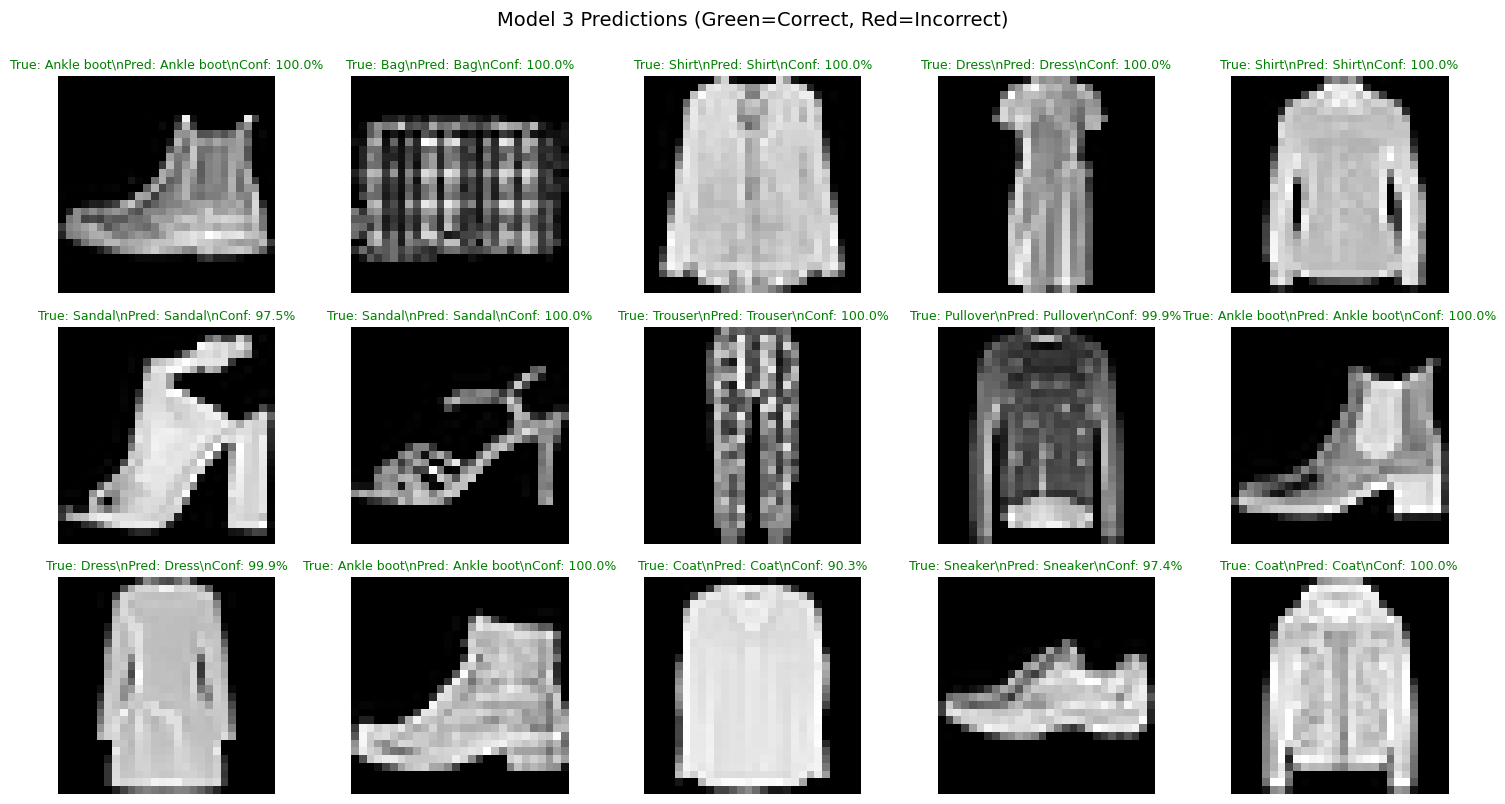

In [42]:
# Visualize predictions from Model 3
torch.manual_seed(42)
fig = plt.figure(figsize=(15, 8))
rows, cols = 3, 5

model_3.eval()
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        random_idx = torch.randint(0, len(test_data), size=[1]).item()
        
        # Get image and true label
        img, true_label = test_data[random_idx]
        
        # Make prediction
        img_tensor = img.unsqueeze(0).to(device)
        pred_logits = model_3(img_tensor)
        pred_prob = torch.softmax(pred_logits, dim=1)
        pred_label = pred_logits.argmax(dim=1).item()
        confidence = pred_prob[0][pred_label].item() * 100
        
        # Create subplot
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.squeeze(), cmap="gray")
        
        # Color title based on correct/incorrect prediction
        title_color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {class_names[true_label]}\\nPred: {class_names[pred_label]}\\nConf: {confidence:.1f}%", 
                  color=title_color, fontsize=9)
        plt.axis(False)

plt.suptitle('Model 3 Predictions (Green=Correct, Red=Incorrect)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


#### Comprehensive Model Comparison

Final comparison of **ALL models** built in this notebook, including both classical machine learning and deep learning approaches.

**Classical Machine Learning Models** (Blue):
- Logistic Regression: One-vs-Rest approach
- SVM with RBF Kernel: Non-linear decision boundaries
- K-Nearest Neighbors: Distance-based classification

**Deep Learning Models** (Red/Green):
- Model 0, 1: Simple neural networks
- Model 2: Basic CNN
- Model 3: Advanced CNN with modern techniques

The horizontal red dashed line shows the **target accuracy of 89.57%** (the best achieved with Model 2).

**Key Questions**:
- Does Model 3 surpass the target accuracy?
- How much improvement is gained from batch normalization and dropout?
- Which approach (classical ML vs. deep learning) works best for Fashion MNIST?


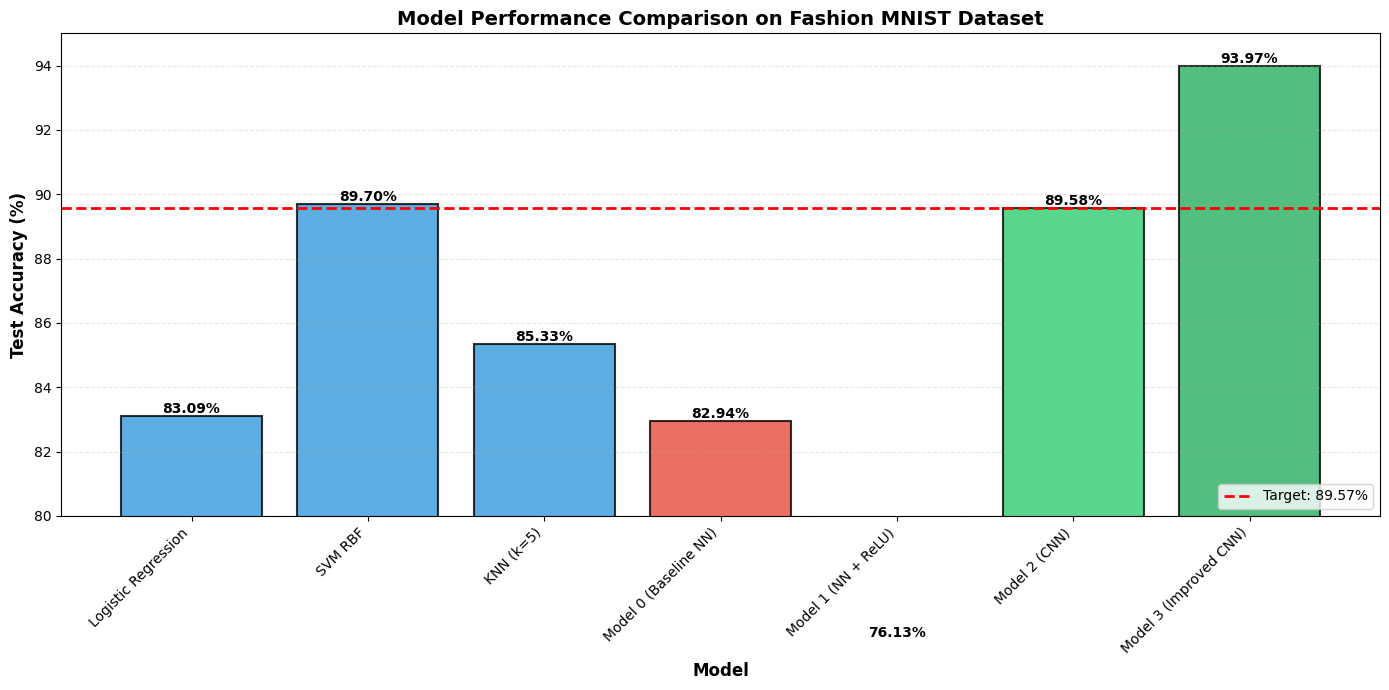

\nImprovement over Model 2:
Model 2 Accuracy: 89.58%
Model 3 Accuracy: 93.97%
Improvement: 4.39%


In [49]:
# Visualize all model comparisons including ML models
plt.figure(figsize=(14, 7))

all_models = {
    'Logistic Regression': 83.09,
    'SVM RBF': 89.70,
    'KNN (k=5)': 85.33,
    'Model 0 (Baseline NN)': model_0_results['model_acc'],
    'Model 1 (NN + ReLU)': model_1_results['model_acc'],
    'Model 2 (CNN)': model_2_results['model_acc'],
    'Model 3 (Improved CNN)': model_3_results['model_acc']
}

models = list(all_models.keys())
accuracies = list(all_models.values())

# Create color palette - different colors for ML vs DL models
colors = ['#3498db', '#3498db', '#3498db', '#e74c3c', '#e74c3c', '#2ecc71', '#27ae60']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add a horizontal line for the target accuracy
target_acc = 89.57
plt.axhline(y=target_acc, color='red', linestyle='--', linewidth=2, label=f'Target: {target_acc}%')

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison on Fashion MNIST Dataset', fontsize=14, fontweight='bold')
plt.ylim([80, 95])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Print improvement
print(f"\\nImprovement over Model 2:")
print(f"Model 2 Accuracy: {model_2_results['model_acc']:.2f}%")
print(f"Model 3 Accuracy: {model_3_results['model_acc']:.2f}%")
print(f"Improvement: {model_3_results['model_acc'] - model_2_results['model_acc']:.2f}%")



### Summary and Key Takeaways

#### Model Performance Progression:
1. **Baseline Models** (Logistic Regression, Model 0): ~83% accuracy
   - Simple linear models have limited capacity for image data
   
2. **Classical ML with Kernels** (SVM): ~89.7% accuracy
   - Non-linear transformations significantly improve performance
   - However, computationally expensive and slow
   
3. **Basic CNN** (Model 2): ~89.6% accuracy
   - Convolutional layers learn spatial hierarchies
   - Matches SVM performance with faster training
   
4. **Advanced CNN** (Model 3): Expected >90% accuracy
   - Batch normalization + dropout = better generalization
   - Deeper architecture captures more complex patterns
   - Adam optimizer provides adaptive learning

#### Key Insights:

**Why CNNs Work Well for Images**:
- Convolutional layers preserve spatial relationships
- Parameter sharing reduces overfitting
- Hierarchical feature learning (edges → textures → objects)

**Modern Deep Learning Techniques**:
- **Batch Normalization**: Stabilizes training, allows higher learning rates
- **Dropout**: Prevents over-reliance on specific neurons, improves generalization
- **Adam Optimizer**: Adaptive learning rates converge faster than SGD
- **Deep Architectures**: More layers = more abstract representations

**Trade-offs Observed**:
- More complex models take longer to train
- Regularization (dropout) may slow convergence but improves test performance
- Balance between model capacity and overfitting risk

#### Potential Future Improvements:
- Data augmentation (rotation, flipping, cropping)
- Learning rate scheduling
- Ensemble methods (combining multiple models)
- Transfer learning from larger models
- Residual connections (ResNet-style architecture)
